In [2]:
# -*- coding: utf-8 -*-
"""
Created on Sat Sep  1 16:38:33 2018

@author: jinlong
"""

import os

import zipfile
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
local_weights_file = './tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)
print("pre_trained_model.layers:",pre_trained_model.layers )
print("pre_trained_model.layers size:",np.size(pre_trained_model.layers) )
#include_top=False argument, we load a network that 
#doesn't include the classification layers 
#at the top—ideal for feature extraction.
for layer in pre_trained_model.layers:
  layer.trainable = False
  
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output



pre_trained_model.layers: [<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001AC795B5320>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001AC795E0390>, <tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x000001AC7956FBE0>, <tensorflow.python.keras.layers.core.Activation object at 0x000001AC795247F0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001AC792AFBE0>, <tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x000001AC8EC32A90>, <tensorflow.python.keras.layers.core.Activation object at 0x000001AC8EC32F60>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001AC6083B4A8>, <tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x000001AC6087FF98>, <tensorflow.python.keras.layers.core.Activation object at 0x000001AC6087FFD0>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001AC608B2FD0>, <tensorflow.python.keras.l

In [3]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024/32, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = Model(pre_trained_model.input, x)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc'])


#local_zip = .'/tmp/cats_and_dogs_filtered.zip'zip_ref = zipfile.ZipFile(local_zip, 'r')#zip_ref.extractall('./tmp')
#zip_ref.close()

# Define our example directories and files
base_dir = './tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)


print("end")
#ResourceExhaustedError: OOM when allocating tensor with shape[3,3,192,320] and type float on
#/job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
#[10,256,400,528]的第一个参数表示batch_size的大小，第二个参数表示某层卷积核的个数，第三个参数表示图像的高，第四个参数表示图像的长

end


In [5]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,#20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,#20,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=2,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)
print("end")

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/2
 - 37s - loss: 0.5008 - acc: 0.7715 - val_loss: 0.1894 - val_acc: 0.9180
Epoch 2/2
 - 33s - loss: 0.3757 - acc: 0.8295 - val_loss: 0.1753 - val_acc: 0.9340


In [6]:
from tensorflow.keras.optimizers import SGD

unfreeze = False

# Unfreeze all models after "mixed6"
for layer in pre_trained_model.layers:
  if unfreeze:
    layer.trainable = True
  if layer.name == 'mixed6':
    unfreeze = True

# As an optimizer, here we will use SGD 
# with a very low learning rate (0.00001)
model.compile(loss='binary_crossentropy',
              optimizer=SGD(
                  lr=0.00001, 
                  momentum=0.9),
              metrics=['acc'])

In [7]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/50
 - 90s - loss: 0.3426 - acc: 0.8490 - val_loss: 0.1685 - val_acc: 0.9390
Epoch 2/50
 - 38s - loss: 0.3486 - acc: 0.8345 - val_loss: 0.1658 - val_acc: 0.9420
Epoch 3/50
 - 38s - loss: 0.3500 - acc: 0.8485 - val_loss: 0.1633 - val_acc: 0.9410
Epoch 4/50
 - 38s - loss: 0.3399 - acc: 0.8505 - val_loss: 0.1645 - val_acc: 0.9410
Epoch 5/50
 - 38s - loss: 0.3405 - acc: 0.8565 - val_loss: 0.1641 - val_acc: 0.9410
Epoch 6/50
 - 38s - loss: 0.3392 - acc: 0.8390 - val_loss: 0.1615 - val_acc: 0.9400
Epoch 7/50
 - 38s - loss: 0.3306 - acc: 0.8520 - val_loss: 0.1648 - val_acc: 0.9400
Epoch 8/50
 - 38s - loss: 0.3398 - acc: 0.8540 - val_loss: 0.1636 - val_acc: 0.9390
Epoch 9/50
 - 38s - loss: 0.3298 - acc: 0.8645 - val_loss: 0.1631 - val_acc: 0.9410
Epoch 10/50
 - 38s - loss: 0.3358 - acc: 0.8500 - val_loss: 0.1641 - val_acc: 0.9410
Epoch 11/50
 - 38s - loss: 0.3540 - acc: 0.8400 - val_loss: 0.1629 - val_acc: 0.9410
Epoch 12/50
 - 38s - loss: 0.3283 - acc: 0.8660 - val_loss: 0.1613 - val_a

Text(0.5,1,'Training and validation loss')

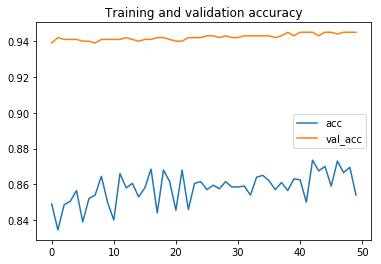

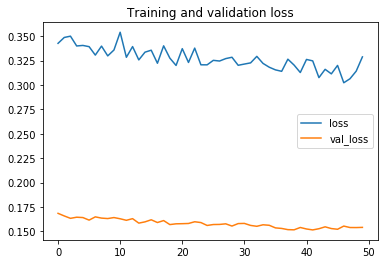

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))
# acc is the accuracy of a batch of training data and val_acc is the accuracy of a batch of testing data.
# Plot training and validation accuracy per epoch
plt.plot(epochs, acc,label="acc")
plt.plot(epochs, val_acc,label="val_acc")
plt.legend(loc="best")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss,label="loss")
plt.plot(epochs, val_loss,label="val_loss")
plt.legend(loc="best")
plt.title('Training and validation loss')